# 0. Preparation

## (Optoinal) mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

2023-04-01 02:15:16.598892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 02:15:16.644030: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 02:15:16.645063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 02:15:17.328577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


42

# Load data from Azure blob

In [5]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "rfr-full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

Data size: (4613880, 52)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'index', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Eval Model

In [8]:
exp_model_dir = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_12_2_gap_fill_tft_2Y_3D_230330_2239" # TODO: Replace to your model dir
best_model_path = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_12_2_gap_fill_tft_2Y_3D_230330_2239/lightning_logs/version_0/checkpoints/epoch=7-step=39640.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*2 # 1 year
ENCODER_LEN = 24*3   # 3 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 17520.


In [9]:
def setup_tsdataset_nogpp_slimfeatures_allowmissing(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=True, # <------- TESTING TFT GAP-FILL METHOD
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7'],
      time_varying_unknown_categoricals=["gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, 
      add_encoder_length=False, 
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [10]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset_nogpp_slimfeatures_allowmissing(train_df, val_df, None, ENCODER_LEN)

Subest length: 17520 timesteps for each sites
Subset num train timesteps: 1281744
Subset num val timesteps: 446232


## Default Evaluation (5 years of validation data)

In [11]:
# Eval on Validation set
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
start = default_timer()
print(f"Start eval on validation.")
val_q_predictions = best_tft.predict(val_dataloader, mode="quantiles", show_progress_bar=True, return_x=False)
eval_time = default_timer() - start
print(f"Val eval time: {eval_time}")

# Get actuals
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# save eval results - also we can resume eval at a later point in time
with open(exp_model_dir + os.sep + "val_actuals.pkl", "wb") as fout:
    pickle.dump(val_actuals, fout)

with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "wb") as fout:
    pickle.dump(val_q_predictions, fout)

Start eval on validation.


Predict: 100%|██████████| 1726/1726 [02:32<00:00, 11.34 batches/s]

Val eval time: 152.21036630799972


In [12]:
reload = False

if reload:
    # load eval results - also we can resume eval at a later point in time
    with open(exp_model_dir + os.sep + "val_actuals.pkl", "rb") as fin:
        val_actuals = pickle.load(fin)

    with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "rb") as fin:
        val_q_predictions = pickle.load(fin)

    #Eval on Validation set
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

    
val_predictions = val_q_predictions[:, :, 3] # p50 == estimation
val_p90 = val_q_predictions[:, :,5] # p90 == estimation
#del val_q_predictions

# Unmasked evaltaion
eval_metric = get_eval_metrics(val_actuals, val_predictions, None, val_p90)
print(f"Unmasked Val eval evaluation: {eval_metric}")

# Masked evlationa
start = default_timer()
mask = torch.logical_not(torch.cat([x['decoder_cat'][:, :, -1].reshape(-1) for x, y in iter(val_dataloader)]))
masked_eval_metric = get_eval_metrics(val_actuals, val_predictions, mask, val_p90)
eval_time = default_timer() - start
print(f"Masked Val eval time: {eval_time}")
print(f"Masked Val eval evaluation: {masked_eval_metric}")

Unmasked Val eval evaluation: {'rmse': 3.6505212783813477, 'mae': 2.017400026321411, 'nse': 0.7322313785552979, 'r2': 0.7322314147943443, 'p50_loss': 0.5070680379867554, 'p90_loss': 0.2836453914642334}
Masked Val eval time: 10.287517794999985
Masked Val eval evaluation: {'rmse': 3.6505212783813477, 'mae': 2.017400026321411, 'nse': 0.7322313785552979, 'r2': 0.7322314147943443, 'p50_loss': 0.5070680379867554, 'p90_loss': 0.2836453914642334}


# Model Interpreation

Subest length: 17520 timesteps for each sites
Subset num train timesteps: 1281744
Subset num val timesteps: 446232


Predict: 100%|██████████| 6904/6904 [06:05<00:00, 18.88 batches/s]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x225 with 1 Axes>,
 'encoder_variables': <Figure size 700x700 with 1 Axes>,
 'decoder_variables': <Figure size 700x675 with 1 Axes>}

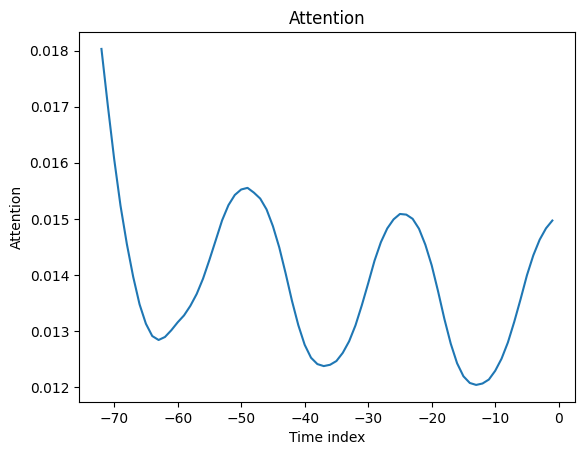

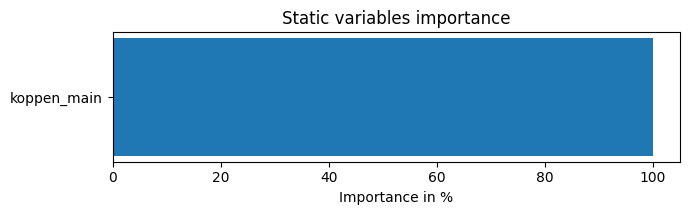

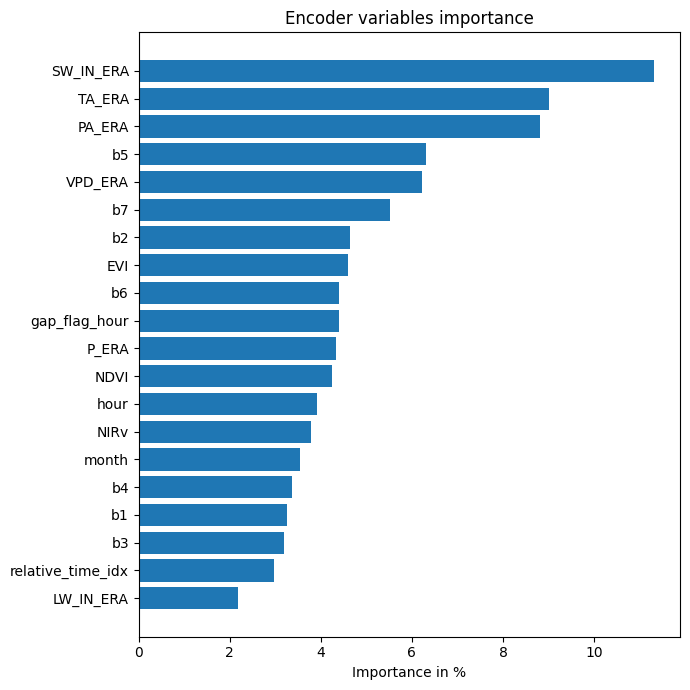

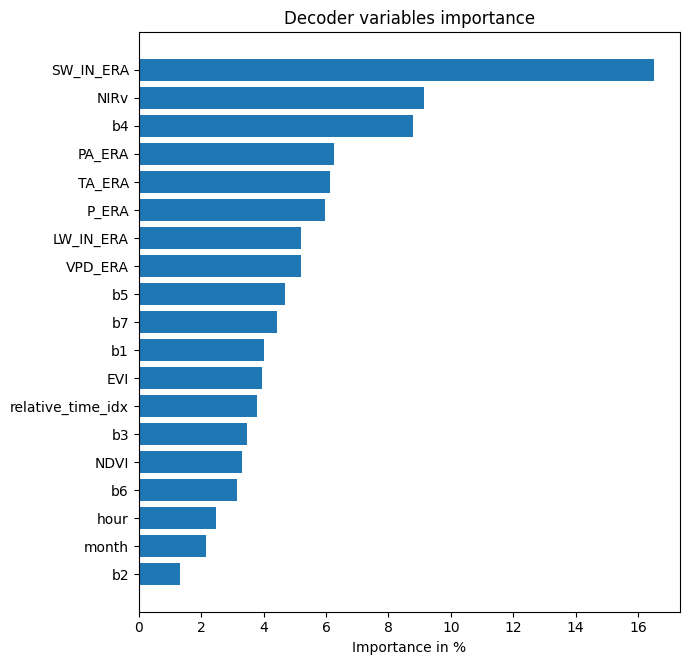

In [13]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset_nogpp_slimfeatures_allowmissing(train_df, val_df, None, ENCODER_LEN)
raw_predictions = best_tft.predict(validation, mode="raw",  show_progress_bar=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Feature-Level Attention

In [18]:
for key in raw_predictions.keys():
    print(f"key: {key}, shape: {raw_predictions[key].shape}")
    
print(raw_predictions["encoder_attention"][0])

key: prediction, shape: torch.Size([441840, 1, 7])
key: encoder_attention, shape: torch.Size([441840, 1, 1, 72])
key: decoder_attention, shape: torch.Size([441840, 1, 1, 1])
key: static_variables, shape: torch.Size([441840, 1, 1])
key: encoder_variables, shape: torch.Size([441840, 72, 1, 20])
key: decoder_variables, shape: torch.Size([441840, 1, 1, 19])
key: decoder_lengths, shape: torch.Size([441840])
key: encoder_lengths, shape: torch.Size([441840])


In [129]:
ex1 = raw_predictions["encoder_variables"][0][0][0]
print(ex1)

tensor([0.0369, 0.0458, 0.0421, 0.0295, 0.1662, 0.0042, 0.0578, 0.0589, 0.1098,
        0.0055, 0.0273, 0.0563, 0.0147, 0.0629, 0.0311, 0.0801, 0.0593, 0.0106,
        0.0897, 0.0114])


In [131]:
x, y = next(iter(val_dataloader))
x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [60]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")

for key in interpretation.keys():
    print(f"key: {key}, shape: {interpretation[key].shape}")

key: attention, shape: torch.Size([72])
key: static_variables, shape: torch.Size([1])
key: encoder_variables, shape: torch.Size([20])
key: decoder_variables, shape: torch.Size([19])
key: encoder_length_histogram, shape: torch.Size([73])
key: decoder_length_histogram, shape: torch.Size([1])


In [68]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="none")

for key in interpretation.keys():
    print(f"key: {key}, shape: {interpretation[key].shape}")

key: attention, shape: torch.Size([441840, 72])
key: static_variables, shape: torch.Size([441840, 1])
key: encoder_variables, shape: torch.Size([441840, 20])
key: decoder_variables, shape: torch.Size([441840, 19])
key: encoder_length_histogram, shape: torch.Size([73])
key: decoder_length_histogram, shape: torch.Size([1])


In [90]:
best_tft.multihead_attn

InterpretableMultiHeadAttention(
  (dropout): Dropout(p=0.2, inplace=False)
  (v_layer): Linear(in_features=16, out_features=16, bias=True)
  (q_layers): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (k_layers): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (attention): ScaledDotProductAttention(
    (softmax): Softmax(dim=2)
  )
  (w_h): Linear(in_features=16, out_features=16, bias=False)
)

In [139]:
best_tft.multihead_attn.v_layer.weight.shape

torch.Size([16, 16])